In [8]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Assuming many-to-one
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

# Assuming the parameters for the LSTM model
input_size = 21
hidden_size = 128
num_layers = 3
output_size = 1

# Create an instance of LSTMModel
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_model

LSTMModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
dfs = []
labels = []
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_combined = pd.merge(df_result, df_textural, how="left", on=["Date"])
    df_combined = pd.merge(df_combined, df_numerical, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date'])
    dfs.append(df_combined)
    labels.append(df_result['Close'])
test_size = 1

train_features = torch.cat([torch.tensor(df.values).float() for df in dfs[:-test_size]])  # Assuming dfs[:-test_size] would work this way
train_labels = torch.cat([torch.tensor(label.values).float() for label in labels[:-test_size]])  # Similar handling for labels

test_features = torch.cat([torch.tensor(df.values).float() for df in dfs[-test_size:]])  # Assuming dfs[:-test_size] would work this way
test_labels = torch.cat([torch.tensor(label.values).float() for label in labels[-test_size:]])  # Similar handling for labels

train_features = train_features.view(4, -1, 21)
test_features = test_features.view(4, -1, 21)
train_labels = train_labels.view(4, -1) 
test_labels = test_labels.view(4, -1) 

# Create TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoader
# Here batch_size is 1 because each batch is already pre-prepared
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches


In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions
def generate_predictions(data, model):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = model.init_hidden(1)  # Initialize hidden state for the start of the sequence

    with torch.no_grad():  
        for i in range(data.size(0)):
            output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden state
            predictions.append(output.squeeze().item())  # Collect the prediction
    return predictions

In [11]:
from tqdm import tqdm

def train_model(loader, model, optimizer, criterion, epochs):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                total_loss += loss.item()

        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_model(train_loader, lstm_model, optimizer, criterion, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 100/1000 [15:35<2:11:53,  8.79s/it]

Epoch 100, Average Loss: 101279492.02492724


 20%|██        | 200/1000 [31:05<2:06:52,  9.52s/it]

Epoch 200, Average Loss: 35210805.11290807


 30%|███       | 300/1000 [46:56<1:51:53,  9.59s/it]

Epoch 300, Average Loss: 49124383.908777006


 40%|████      | 400/1000 [1:03:02<1:42:07, 10.21s/it]

Epoch 400, Average Loss: 54388238.62294614


 50%|█████     | 500/1000 [1:18:16<1:10:23,  8.45s/it]

Epoch 500, Average Loss: 82662284.56384195


 60%|██████    | 600/1000 [1:32:22<48:24,  7.26s/it]  

Epoch 600, Average Loss: 20167787.777065508


 70%|███████   | 700/1000 [1:45:31<47:50,  9.57s/it]

Epoch 700, Average Loss: 13422883.574273527


 80%|████████  | 800/1000 [2:01:53<31:51,  9.56s/it]

Epoch 800, Average Loss: 249336024.63799572


 90%|█████████ | 900/1000 [2:17:10<13:27,  8.07s/it]

Epoch 900, Average Loss: 10324077.601853356


100%|██████████| 1000/1000 [2:32:50<00:00,  9.17s/it]

Epoch 1000, Average Loss: 202465293.94800627


<built-in method size of Tensor object at 0x31e0c0e10>
133.05487060546875
23.5972900390625
3.25469970703125
1.2960205078125
-57.93560791015625
39.9844970703125
37.63897705078125
8.9520263671875
42.537109375
118.39849853515625
66.09490966796875
128.3565673828125
132.61541748046875
106.5196533203125
121.45599365234375
113.7923583984375
120.50897216796875
113.33270263671875
118.28790283203125
113.36981201171875
115.00115966796875
113.60284423828125
112.20404052734375
113.45977783203125
109.060791015625
113.27032470703125
106.11248779296875
112.88067626953125
103.34722900390625
112.34625244140625
101.19683837890625
111.62554931640625
100.18365478515625
110.6905517578125
100.98565673828125
109.57135009765625
103.77105712890625
108.7684326171875
107.20196533203125
109.20166015625
109.63543701171875
110.48992919921875
111.0645751953125
111.53314208984375
111.882568359375
112.14739990234375
112.35162353515625
112.51385498046875
112.64617919921875
112.75665283203125
112.85040283203125
112.93096

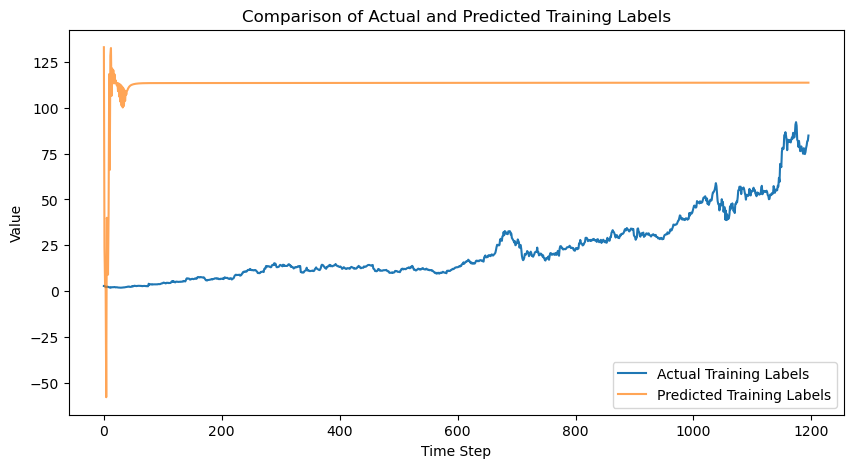

<built-in method size of Tensor object at 0x31d4f5c70>
133.05487060546875
23.5972900390625
3.25469970703125
1.2960205078125
-57.93560791015625
39.9844970703125
37.63897705078125
8.9520263671875
42.537109375
118.39849853515625
66.09490966796875
128.3565673828125
132.61541748046875
106.5196533203125
121.45599365234375
113.7923583984375
120.50897216796875
113.33270263671875
118.28790283203125
113.36981201171875
115.00115966796875
113.60284423828125
112.20404052734375
113.45977783203125
109.060791015625
113.27032470703125
106.11248779296875
112.88067626953125
103.34722900390625
112.34625244140625
101.19683837890625
111.62554931640625
100.18365478515625
110.6905517578125
100.98565673828125
109.57135009765625
103.77105712890625
108.7684326171875
107.20196533203125
109.20166015625
109.63543701171875
110.48992919921875
111.0645751953125
111.53314208984375
111.882568359375
112.14739990234375
112.35162353515625
112.51385498046875
112.64617919921875
112.75665283203125
112.85040283203125
112.93096

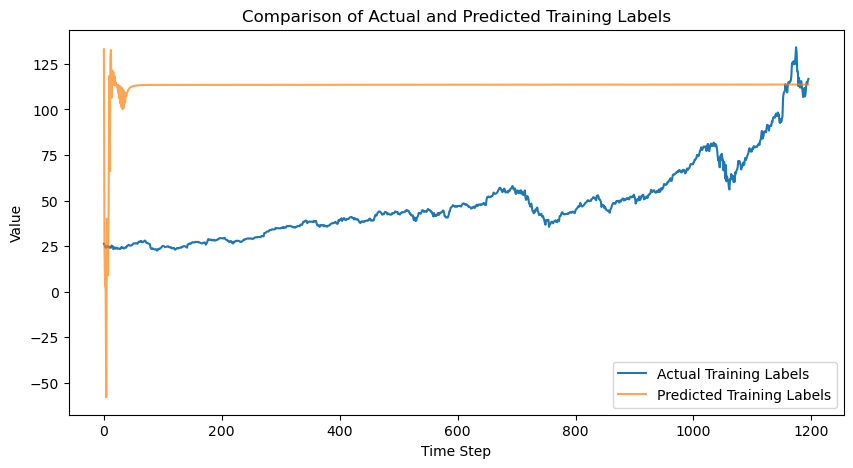

<built-in method size of Tensor object at 0x31b9f71b0>
133.05487060546875
23.5972900390625
3.25469970703125
1.2960205078125
-57.93560791015625
39.9844970703125
37.63897705078125
8.9520263671875
42.537109375
118.39849853515625
66.09490966796875
128.3565673828125
132.61541748046875
106.5196533203125
121.45599365234375
113.7923583984375
120.50897216796875
113.33270263671875
118.28790283203125
113.36981201171875
115.00115966796875
113.60284423828125
112.20404052734375
113.45977783203125
109.060791015625
113.27032470703125
106.11248779296875
112.88067626953125
103.34722900390625
112.34625244140625
101.19683837890625
111.62554931640625
100.18365478515625
110.6905517578125
100.98565673828125
109.57135009765625
103.77105712890625
108.7684326171875
107.20196533203125
109.20166015625
109.63543701171875
110.48992919921875
111.0645751953125
111.53314208984375
111.882568359375
112.14739990234375
112.35162353515625
112.51385498046875
112.64617919921875
112.75665283203125
112.85040283203125
112.93096

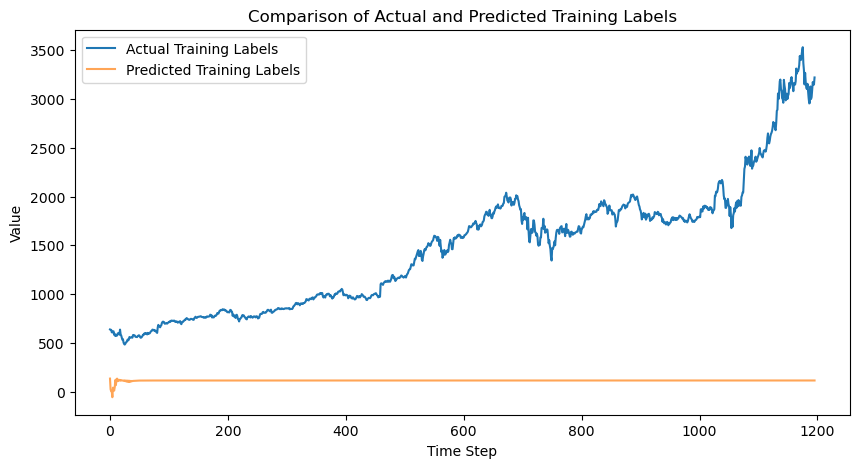

<built-in method size of Tensor object at 0x31d45f520>
133.05487060546875
23.5972900390625
3.25469970703125
1.2960205078125
-57.93560791015625
39.9844970703125
37.63897705078125
8.9520263671875
42.537109375
118.39849853515625
66.09490966796875
128.3565673828125
132.61541748046875
106.5196533203125
121.45599365234375
113.7923583984375
120.50897216796875
113.33270263671875
118.28790283203125
113.36981201171875
115.00115966796875
113.60284423828125
112.20404052734375
113.45977783203125
109.060791015625
113.27032470703125
106.11248779296875
112.88067626953125
103.34722900390625
112.34625244140625
101.19683837890625
111.62554931640625
100.18365478515625
110.6905517578125
100.98565673828125
109.57135009765625
103.77105712890625
108.7684326171875
107.20196533203125
109.20166015625
109.63543701171875
110.48992919921875
111.0645751953125
111.53314208984375
111.882568359375
112.14739990234375
112.35162353515625
112.51385498046875
112.64617919921875
112.75665283203125
112.85040283203125
112.93096

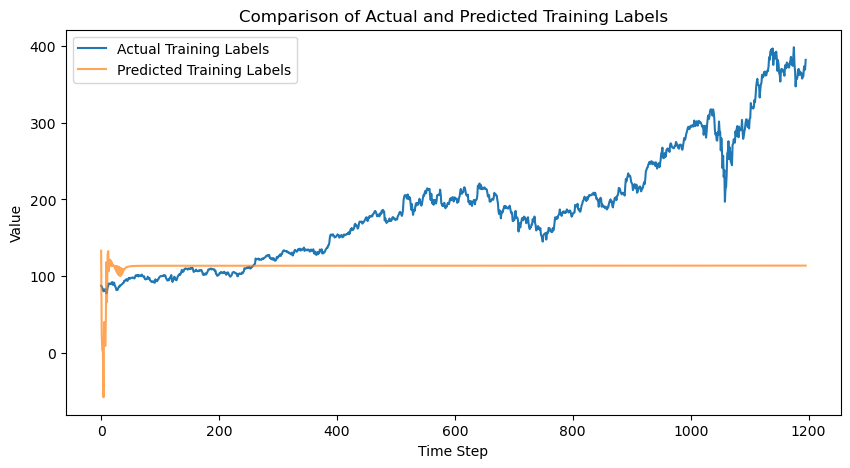

In [34]:
for data, labels in train_loader:
    train_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    train_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format

    # Plot the actual and predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(train_labels_list, label='Actual Training Labels')
    plt.plot(train_predictions, label='Predicted Training Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Training Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()